# 🔎 Análisis Exploratorio de Datos (Google):

## Importación de librerias

In [6]:
from textblob import TextBlob
import datetime
import inspect
import re
import matplotlib.pyplot as plt
import inspect
import pandas as pd
import gzip
import os
import seaborn as sns
import numpy as np
from data_utils import data_type_check

### Importación de los datasets

In [7]:
df_metadata = pd.read_parquet('../0_Dataset/Data_Limpia/Google/G_metadata_FL.parquet', engine='pyarrow')
df_review = pd.read_parquet('../0_Dataset/Data_Limpia/Google/G_review_FL_reducido.parquet', engine='pyarrow')

### Funciones importantes

In [9]:
# FUNCION PARA ENCONTRAR OUTLIERS CON EL RANGO INTERCUARTILICO
def encontrar_outliers_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

In [10]:
# FUNCION PARA ENCONTRAR OUTLIERS CON LA REGLA DE LAS 3 SIGMAS
def encontrar_outliers_3sigmas(data):
    mean = data.mean()
    std = data.std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    return data[(data < lower_bound) | (data > upper_bound)]

## EDA

Verificación de los datos

In [18]:
df_metadata.head(5)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Neurocare & Family Services,"Neurocare & Family Services, 1749 S Naperville...",0x880e55ddb0081907:0x1dc5f1650b07c388,None,41.839291,-88.100503,[Doctor],5.0,1,None,"[[Monday, Closed], [Tuesday, 8AM–10PM], [Wedne...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 8AM Tue,"[0x880e55ddba9f7635:0x862c597b017011c1, 0x880e...",https://www.google.com/maps/place//data=!4m2!3...
1,Bayview Canvas,"Bayview Canvas, 22460 Glass Ln, Port Charlotte...",0x146c6dea0e8465f9:0xca5e7f14cefd4983,None,26.962494,-82.075552,[Upholstery shop],5.0,1,None,"[[Friday, 8AM–5PM], [Saturday, Closed], [Sunda...","{'Accessibility': None, 'Activities': None, 'A...",Open ⋅ Closes 5PM,"[0x88dca9b000000001:0xae92d5429c06878a, 0x88db...",https://www.google.com/maps/place//data=!4m2!3...
2,Peluquería Acapulco Barbershop,"Peluquería Acapulco Barbershop, 1014 Gault Ave...",0x8861d6398caaf079:0x7a735e53dfeac495,None,34.450636,-85.714130,[Barber shop],4.8,58,None,"[[Saturday, 10AM–5PM], [Sunday, Closed], [Mond...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 10AM,"[0x8861d640f8cf4415:0xc50ef1793d0439da, 0x8861...",https://www.google.com/maps/place//data=!4m2!3...
3,Mountain Travelers Hike and Ski Shop,"Mountain Travelers Hike and Ski Shop, 147 US-4...",0x89e024365cd93733:0x97f767d0409e00af,None,43.622089,-72.953674,"[Ski shop, Camping store, Car accessories store]",4.4,26,None,"[[Thursday, 10AM–5PM], [Friday, 10AM–5PM], [Sa...",None,Permanently closed,"[0x89e024ecbaaafc07:0xf913f5e468d2db08, 0x89e0...",https://www.google.com/maps/place//data=!4m2!3...
4,Lovely Nails,"Lovely Nails, 636 Brandon Ave SW, Roanoke, VA ...",0x884d0da7e0e9de07:0xfaeb98dff1ad0e89,None,37.254535,-79.959470,[Nail salon],4.3,145,None,"[[Monday, 9:30AM–7:30PM], [Tuesday, 9:30AM–7:3...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 9:30AM Tue,"[0x884d0cff3546c2e1:0xf91b9ff679bd14aa, 0x884d...",https://www.google.com/maps/place//data=!4m2!3...


In [25]:
df_metadata.price.value_counts()

price
$       8785
$$      7503
$$$      558
$$$$      60
Name: count, dtype: int64

In [38]:
df_review.head()

,user_id,name,rating,gmap_id,dates,year,month,day
0,1.145803e+20,jose martinez,5,0x88d9b684949c6fa1:0x5da9b5c4bd240d6b,2018-05-03 22:03:25.812,2018,May,3
1,1.077641e+20,Ian Horow,5,0x88d901c07a850b25:0x53258790576101e6,2021-05-02 19:59:27.951,2021,May,2
2,1.003756e+20,Lauren Palmer,5,0x8890c53f737b08dd:0x9b2fc3221b8c1fff,2020-11-10 22:13:24.419,2020,November,10
3,1.102839e+20,Merrilee Crank,5,0x88e7c6dcd2e0a14d:0xb3b8214e70fb8540,2018-05-22 17:37:17.476,2018,May,22
4,1.156291e+20,Sincere Dread,5,0x88c2e3863fb052d5:0xc7dd0c27ad588473,2019-07-25 20:36:11.867,2019,July,25


Eliminación de columnas innecesarias

In [21]:
df_metadata.drop(columns=['relative_results','url'],inplace=True)

### 1. Información y transformación de los datos

#### Análisis de nulos

In [39]:
print(data_type_check(df_metadata))
print(data_type_check(df_review))


 Resumen del dataframe:

Dimensiones:  (212299, 8)
          columna  %_no_nulos  %_nulos  total_nulos tipo_dato
0            name       100.0      0.0            0    object
1         address       100.0      0.0            0    object
2         gmap_id       100.0      0.0            0    object
3        latitude       100.0      0.0            0   float64
4       longitude       100.0      0.0            0   float64
5        category       100.0      0.0            0    object
6      avg_rating       100.0      0.0            0   float64
7  num_of_reviews       100.0      0.0            0     int64
None

 Resumen del dataframe:

Dimensiones:  (712500, 8)
   columna  %_no_nulos  %_nulos  total_nulos       tipo_dato
0  user_id       100.0      0.0            0         float64
1     name       100.0      0.0            0          object
2   rating       100.0      0.0            0           int64
3  gmap_id       100.0      0.0            0          object
4    dates       100.0      

📚 Conclusiones:
- En "df_metadata" las variables description, price, hours, MISC, state, tienen una cantidad considerablemente grande de nulos. Por lo que solo admitiendo para el objetivo de análisis del 18%, se procede a eliminarlas y aportar información relevante para el análisis de datos.
- En "df_rebiew" las variables text, pics, resp, no aportan información relevante para el análisis por lo que se eliminará.
- Se eliminarán los registros que tengan algun dato nulo que son menores al 3% de los datos.

In [24]:
# SE REALIZARÁ UN REINICIO DE INDICES
df_metadata.reset_index(drop=True,inplace=True)
df_review.reset_index(drop=True,inplace=True)

In [27]:
# OBTENEMOS SOLO LAS COLUMNAS QUE NOS VAN A AYUDAR A NUESTRO ANÁLISIS
df_metadata.drop(columns=['description','price', 'hours', 'MISC', 'state'],inplace=True)
df_review.drop(columns=['text','pics','resp'],inplace=True)

In [29]:
# ELIMINACIÓN DE REGISTRO QUE CONTINENEN REGISTRO NULOS
df_metadata.dropna(axis=0,inplace=True)

In [30]:
print(data_type_check(df_metadata))
print(data_type_check(df_review))


 Resumen del dataframe:

Dimensiones:  (212299, 8)
          columna  %_no_nulos  %_nulos  total_nulos tipo_dato
0            name       100.0      0.0            0    object
1         address       100.0      0.0            0    object
2         gmap_id       100.0      0.0            0    object
3        latitude       100.0      0.0            0   float64
4       longitude       100.0      0.0            0   float64
5        category       100.0      0.0            0    object
6      avg_rating       100.0      0.0            0   float64
7  num_of_reviews       100.0      0.0            0     int64
None

 Resumen del dataframe:

Dimensiones:  (712500, 5)
   columna  %_no_nulos  %_nulos  total_nulos tipo_dato
0  user_id       100.0      0.0            0   float64
1     name       100.0      0.0            0    object
2     time       100.0      0.0            0     int64
3   rating       100.0      0.0            0     int64
4  gmap_id       100.0      0.0            0    object
Non

#### Transformaciones de datos

In [35]:
# TRANSFORMACIÓN DE LA VARIABLE 'time'
df_review['dates'] = pd.to_datetime(df_review['time'], unit='ms')
df_review['year'] = df_review['dates'].dt.year
df_review['month'] = df_review['dates'].dt.strftime('%B')
df_review['day'] = df_review['dates'].dt.day

In [37]:
# ELIMINAMOS LA VARIABLE 'time'
df_review.drop(columns=['time'],inplace=True)

### 2. Variables cuantitativas y categóricas

In [42]:
#CLASIFICAMOS POR TIPO DE VARIABLES
df_metadata_num = df_metadata.select_dtypes('number')
df_metadata_cat = df_metadata.select_dtypes('O')

df_review_num = df_review.select_dtypes('number')
df_review_cat = df_review.select_dtypes('O')

In [44]:
print(df_metadata_num.head())
print(df_metadata_cat.head())
print(df_review_num.head())
print(df_review_cat.head())

    latitude  longitude  avg_rating  num_of_reviews
0  41.839291 -88.100503         5.0               1
1  26.962494 -82.075552         5.0               1
2  34.450636 -85.714130         4.8              58
3  43.622089 -72.953674         4.4              26
4  37.254535 -79.959470         4.3             145
                                   name  \
0           Neurocare & Family Services   
1                        Bayview Canvas   
2        Peluquería Acapulco Barbershop   
3  Mountain Travelers Hike and Ski Shop   
4                          Lovely Nails   

                                             address  \
0  Neurocare & Family Services, 1749 S Naperville...   
1  Bayview Canvas, 22460 Glass Ln, Port Charlotte...   
2  Peluquería Acapulco Barbershop, 1014 Gault Ave...   
3  Mountain Travelers Hike and Ski Shop, 147 US-4...   
4  Lovely Nails, 636 Brandon Ave SW, Roanoke, VA ...   

                                 gmap_id  \
0  0x880e55ddb0081907:0x1dc5f1650b07c388   
1  0

#### Análisis de variables cuantitativas

Para la obtención de outliers, utilizamos las funciones
- encontrar_outliers_IQR
- encontrar_outliers_3sigmas

In [ ]:
encontrar_outliers_IQR(df_metadata)

### 3. Variables categóricas y cuantitativas

In [21]:
# VARIABLE CATEGÓRICAS Y CUANTITATIVAS EXISTENTES EN EL DATASET
df_metadata_cat = df_metadata.select_dtypes('O')
df_metadata_num = df_metadata.select_dtypes('number')

#### Variables cuantitativas

In [25]:
# MUESTRA DEL DATASET
df_metadata_num.head(5)

,latitude,longitude,avg_rating,num_of_reviews
0,41.839291,-88.100503,5.0,1
1,26.962494,-82.075552,5.0,1
2,34.450636,-85.714130,4.8,58
3,43.622089,-72.953674,4.4,26
4,37.254535,-79.959470,4.3,145


In [32]:
# DESCRIPCIÓN ESTADISTICO DE LOS DATOS NUMÉRICOS
df_metadata_num.loc[:,['avg_rating','num_of_reviews']].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_rating,212299.0,4.298270,0.729039,1.0,4.0,4.5,4.8,5.0
num_of_reviews,212299.0,33.826127,72.807075,1.0,6.0,15.0,37.0,6960.0


'Se aprecia que la mayoría de los restaurantes tienen calificación de 4.0 a 5.0.\nEn su mayoría estos restaurantes están calificados positivamente'

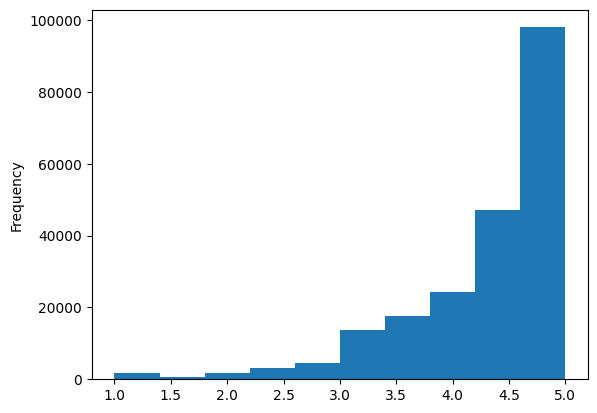

In [30]:
# HISTOGRAMA DE LA CANTIDAD DE CALIFICACIÓN QUE SE DA LOS RESTAURANTES
df_metadata_num.avg_rating.plot.hist()
"""Se aprecia que la mayoría de los restaurantes tienen calificación de 4.0 a 5.0.
En su mayoría estos restaurantes están calificados positivamente"""

In [34]:
# SE ENCUENTRA LA FRECUENCIA DE LAS CALIFICACIONES
freq_rates = df_metadata_num.avg_rating.value_counts().reset_index()
freq_rates.columns = ['Ratings', 'Frequency']

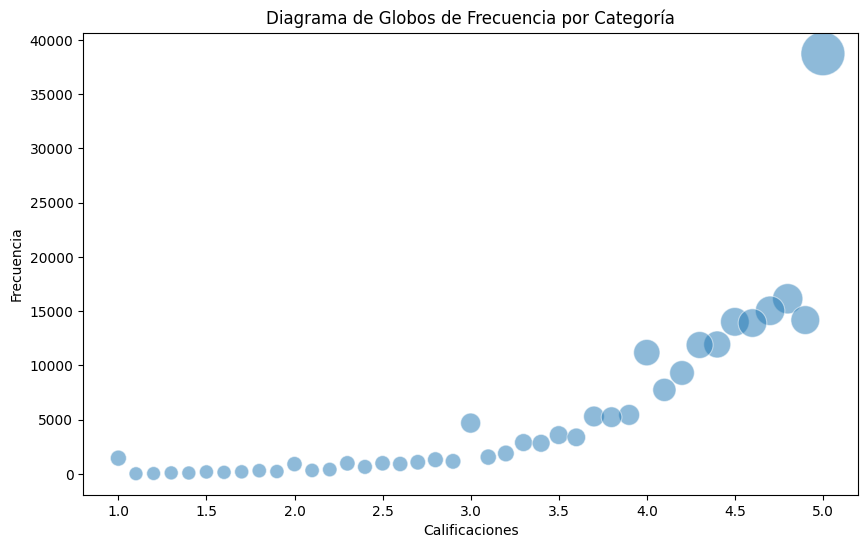

In [38]:
# GRAFICO DE BURBUJAS DE LAS CALIFICACIONES
plt.figure(figsize=(10, 6))
sns.scatterplot(data=freq_rates, x='Ratings', y='Frequency', size='Frequency', sizes=(100, 1000), alpha=0.5, legend=False)
plt.xlabel('Calificaciones')
plt.ylabel('Frecuencia')
plt.title('Diagrama de Globos de Frecuencia por Categoría')
plt.show()

#### Outliers

In [55]:
# SE ENCUENTRA LOS OUTLIERS POR MEDIO DEL RANGO INTERCUARTILICO
print(encontrar_outliers_IQR(df_metadata_num.avg_rating).value_counts())

# SE ENCUENTRA LOS OUTLIERS POR MEDIO DEL METODO DE LAS 3 SIGMAS
print(encontrar_outliers_3sigmas(df_metadata_num.avg_rating).value_counts())

avg_rating
1.0    1455
2.8    1311
2.7    1079
2.5     984
2.3     978
2.6     918
2.0     907
2.4     650
2.2     406
2.1     324
1.8     303
1.9     223
1.7     196
1.5     185
1.6     147
1.3      98
1.4      88
1.2      39
1.1      21
Name: count, dtype: int64
avg_rating
1.0    1455
2.0     907
2.1     324
1.8     303
1.9     223
1.7     196
1.5     185
1.6     147
1.3      98
1.4      88
1.2      39
1.1      21
Name: count, dtype: int64


In [56]:
outliers = encontrar_outliers_IQR(df_metadata_num.avg_rating)

In [62]:
outliers

18        1.9
27        2.8
48        1.0
50        1.0
56        1.0
         ... 
219871    2.0
219872    2.8
219895    2.7
219899    2.4
219943    1.9
Name: avg_rating, Length: 10312, dtype: float64

In [2]:
# FILTRAMOS SIN LOS OUTLIERS
filtro_outliers = df_metadata_num.avg_rating >= outliers.max()
df_filtrado = df_metadata_num.avg_rating[filtro_outliers]

NameError: name 'df_metadata_num' is not defined

In [1]:
df_filtrado.plot.hist()
plt.xlabel('Categoría de Calificaciones')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Categoría de Calificaciones sin Outliers')
plt.show()

NameError: name 'df_filtrado' is not defined

: 

In [54]:
encontrar_outliers_3sigmas(df_metadata_num.avg_rating).value_counts()

avg_rating
1.0    1455
2.0     907
2.1     324
1.8     303
1.9     223
1.7     196
1.5     185
1.6     147
1.3      98
1.4      88
1.2      39
1.1      21
Name: count, dtype: int64

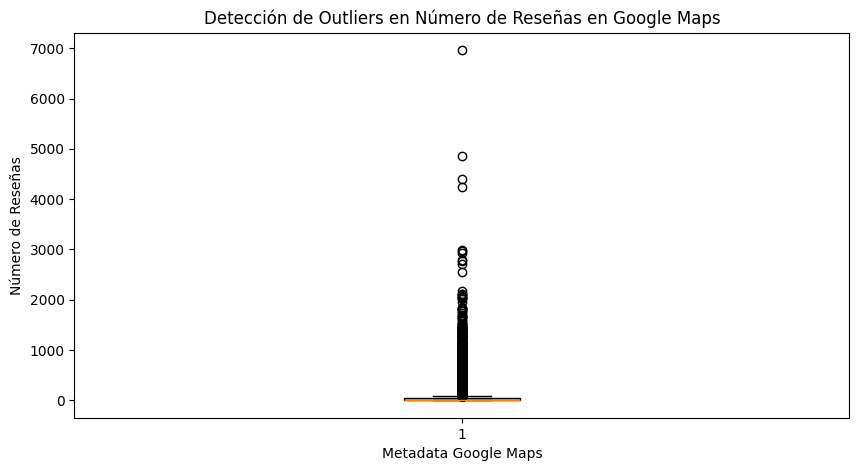

In [39]:
# GRAFICO DE CAJA Y BIGOTES PARA EL NUMERO DE REVIEWS
plt.figure(figsize=(10, 5))
plt.boxplot(df_metadata_num['num_of_reviews'], patch_artist=True, boxprops=dict(facecolor='lightcyan'))
plt.xlabel('Metadata Google Maps')
plt.ylabel('Número de Reseñas')
plt.title('Detección de Outliers en Número de Reseñas en Google Maps')
plt.show()

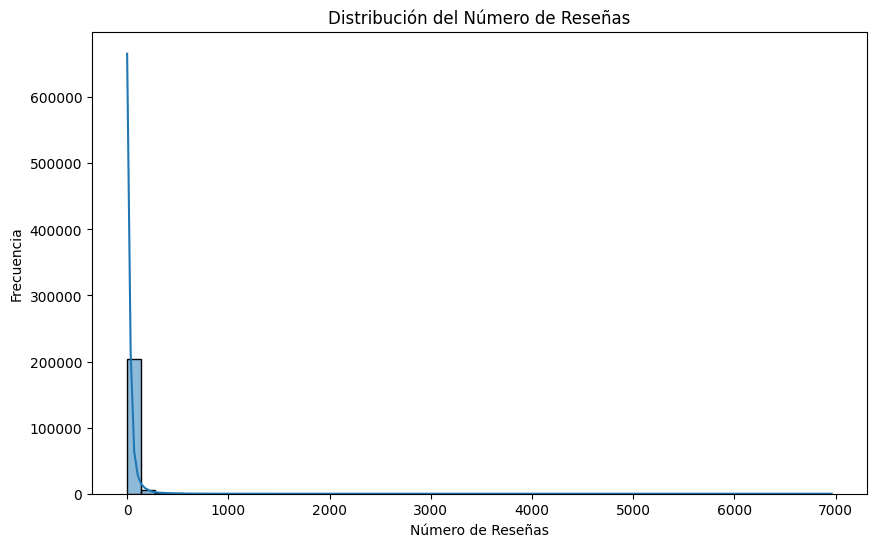

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df_metadata_num['num_of_reviews'], bins=50, kde=True)
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.title('Distribución del Número de Reseñas')
plt.show()

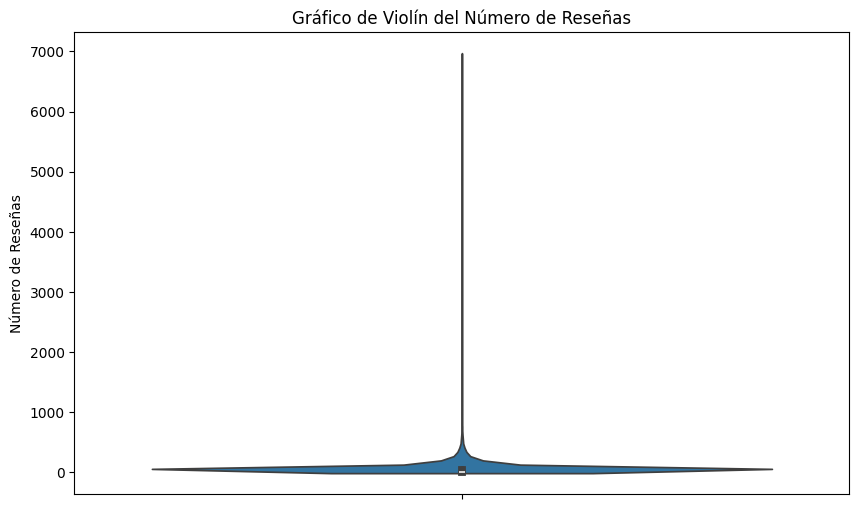

In [42]:
plt.figure(figsize=(10, 6))
sns.violinplot(y=df_metadata_num['num_of_reviews'])
plt.title('Gráfico de Violín del Número de Reseñas')
plt.ylabel('Número de Reseñas')
plt.show()

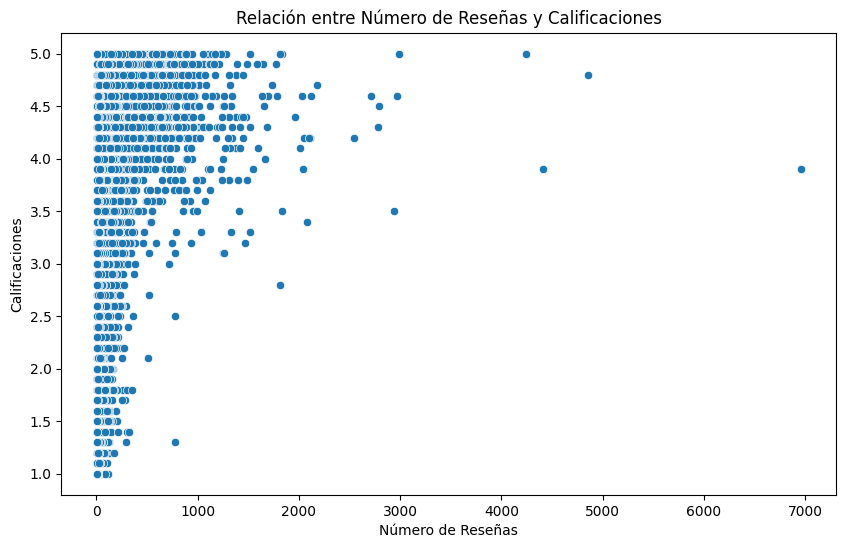

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_of_reviews', y='avg_rating', data=df_metadata_num)
plt.xlabel('Número de Reseñas')
plt.ylabel('Calificaciones')
plt.title('Relación entre Número de Reseñas y Calificaciones')
plt.show()

In [ ]:
# SE ENCUENTRA LA FRECUENCIA DE LAS CALIFICACIONES
freq_rates = df_metadata_num.avg_rating.value_counts().reset_index()
freq_rates.columns = ['Ratings', 'Frequency']

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_metadata_num['num_of_reviews'].value_counts()., x='Ratings', y='Frequency', size='Frequency', sizes=(100, 1000), alpha=0.5, legend=False)
sns.scatterplot(df_metadata_num['num_of_reviews'], patch_artist=True, boxprops=dict(facecolor='lightcyan'))
plt.xlabel('Metadata Google Maps')
plt.ylabel('Número de Reseñas')
plt.title('Detección de Outliers en Número de Reseñas en Google Maps')
plt.show()

#### Variables categóricas

In [29]:
df_metadata_cat.name.value_counts()

name
Subway                          552
United States Postal Service    524
Shell                           472
U-Haul Neighborhood Dealer      392
Redbox                          370
                               ... 
Dennis Meighan, DO                1
Dodge Avenue K9's & Training      1
Us Donuts                         1
Monteith Branch                   1
Mr Falafel Plus                   1
Name: count, Length: 183109, dtype: int64